In [ ]:
# Bank Marketing — Term Deposit Subscription


## What it does (high level):
1. Load data
2. Quick inspection & missingness
3. EDA (printing + saving basic plots)
4. Preprocessing (impute, encode, scale) with ColumnTransformer
5. Train/test split
6. Train baseline models (LogisticRegression, DecisionTree, RandomForest)
7. Evaluate (accuracy, precision, recall, f1, roc-auc) and plot ROC
8. Compare with/without `duration` (leakage)
9. (Optional) GridSearch for RandomForest
10. Feature importances + save model


In [41]:
# load tha data_path
# Config / Imports

DATA_PATH = "/Users/nikhilreddyponnala/Desktop/Data Analytics/Second Project/Client subscribed to a term deposit/bankmarketing.csv"  # change if needed
OUTPUT_DIR = "./outputs"
RANDOM_STATE = 42
TEST_SIZE = 0.2
RUN_PLOTS = True
RUN_GRIDSEARCH = False  # set True if you want to run hyperparameter tuning (may take long)


In [21]:
# Imports the neccessary libraries

import os
import warnings
from typing import Tuple, List, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import joblib

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)


In [23]:
# Helper functions

def detect_target_column(df: pd.DataFrame) -> str:
    candidates = ["y", "subscribed", "term_deposit", "target"]
    for c in candidates:
        if c in df.columns:
            return c
    return df.columns[-1]


def summarize_missingness(df: pd.DataFrame) -> pd.DataFrame:
    miss = df.isna().sum().sort_values(ascending=False)
    pct = (miss / len(df) * 100).round(2)
    out = pd.DataFrame({"missing": miss, "missing_%": pct})
    return out[out["missing"] > 0]


def order_months(series: pd.Series) -> pd.Series:
    month_order = ["jan", "feb", "mar", "apr", "may", "jun",
                   "jul", "aug", "sep", "oct", "nov", "dec"]
    lower_vals = series.astype(str).str.lower().unique().tolist()
    if all(v in month_order for v in lower_vals):
        cat_type = pd.CategoricalDtype(categories=month_order, ordered=True)
        return series.astype(str).str.lower().astype(cat_type)
    return series


def binary_from_series(s: pd.Series) -> np.ndarray:
    """Convert common label formats (yes/no, 1/0, True/False) to binary array."""
    return s.astype(str).str.lower().isin(["yes", "1", "true", "t"]).astype(int).values


In [25]:
# Basic EDA
# (prints summaries and optionally saves some plots)

def basic_eda(df: pd.DataFrame, target_col: str, out_dir: str, include_plots: bool = True):
    print("\\n===== BASIC EDA =====")
    print("Shape:", df.shape)
    print("\\nColumn dtypes:\n", df.dtypes)
    print("\\nHead:\n", df.head())

    print("\\nClass balance:")
    print(df[target_col].value_counts(normalize=True).rename("proportion"))

    miss = summarize_missingness(df)
    if not miss.empty:
        print("\\nMissing values found:\n", miss)
    else:
        print("\\nNo missing values detected.")

    if "month" in df.columns:
        df["month"] = order_months(df["month"])

    if not include_plots:
        return

    os.makedirs(out_dir, exist_ok=True)

    # Numeric histograms
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for col in num_cols:
        plt.figure()
        df[col].hist(bins=30)
        plt.title(f"Histogram: {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f"hist_{col}.png"))
        plt.close()

    # Categorical rate plots for up to 8 categorical columns
    cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
    if target_col in cat_cols:
        cat_cols.remove(target_col)

    for col in cat_cols[:8]:
        plt.figure(figsize=(8,4))
        tmp = (
            df.groupby(col)[target_col]
            .apply(lambda s: binary_from_series(s).mean())
            .sort_values(ascending=False)
        )
        tmp.plot(kind="bar")
        plt.title(f"Subscription Rate by {col}")
        plt.xlabel(col)
        plt.ylabel("Positive rate")
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f"rate_by_{col}.png"))
        plt.close()

    # Correlation heatmap for numeric columns (simple)
    if len(num_cols) >= 2:
        corr = df[num_cols].corr()
        plt.figure(figsize=(8,6))
        im = plt.imshow(corr, aspect="auto")
        plt.colorbar(im)
        plt.title("Correlation Matrix (numeric features)")
        plt.xticks(range(len(num_cols)), num_cols, rotation=90)
        plt.yticks(range(len(num_cols)), num_cols)
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, "correlation_matrix.png"))
        plt.close()


In [27]:
# Preprocessing helper

def build_preprocessor(df: pd.DataFrame, target_col: str, drop_duration: bool = False) -> Tuple[ColumnTransformer, List[str], List[str]]:
    feature_cols = [c for c in df.columns if c != target_col]
    if drop_duration and "duration" in feature_cols:
        feature_cols.remove("duration")

    cat_features = df[feature_cols].select_dtypes(include=["object", "category"]).columns.tolist()
    num_features = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()

    num_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    cat_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_transformer, num_features),
            ("cat", cat_transformer, cat_features),
        ]
    )

    return preprocessor, num_features, cat_features


# Get feature names after the ColumnTransformer has been fitted
def get_feature_names_from_preprocessor(preprocessor: ColumnTransformer) -> List[str]:
    # Numeric
    num_features = preprocessor.transformers_[0][2]
    cat_features = preprocessor.transformers_[1][2]

    ohe = preprocessor.named_transformers_["cat"].named_steps["encoder"]
    try:
        cat_ohe_names = ohe.get_feature_names_out(cat_features).tolist()
    except Exception:
        # fallback
        cat_ohe_names = [f"{c}_{i}" for c in cat_features for i in range(1)]

    return list(num_features) + cat_ohe_names


In [29]:
# Model training & evaluation

def evaluate_model(y_true, y_pred, y_proba=None) -> Dict[str, float]:
    y_true_bin = binary_from_series(pd.Series(y_true))
    y_pred_bin = binary_from_series(pd.Series(y_pred))

    metrics = {
        "accuracy": accuracy_score(y_true_bin, y_pred_bin),
        "precision": precision_score(y_true_bin, y_pred_bin, zero_division=0),
        "recall": recall_score(y_true_bin, y_pred_bin, zero_division=0),
        "f1": f1_score(y_true_bin, y_pred_bin, zero_division=0),
    }
    if y_proba is not None:
        try:
            metrics["roc_auc"] = roc_auc_score(y_true_bin, y_proba)
        except Exception:
            metrics["roc_auc"] = float("nan")
    return metrics


def train_and_evaluate(X_train, X_test, y_train, y_test, preprocessor, random_state=42) -> Tuple[pd.DataFrame, Dict[str, Pipeline], Dict[str, Dict]]:
    models = {
        "LogisticRegression": LogisticRegression(max_iter=1000),
        "DecisionTree": DecisionTreeClassifier(random_state=random_state),
        "RandomForest": RandomForestClassifier(n_estimators=200, random_state=random_state, n_jobs=-1),
    }

    results = []
    fitted_pipelines = {}
    roc_info = {}

    for name, model in models.items():
        pipe = Pipeline(steps=[("preprocess", preprocessor), ("model", model)])
        print(f"\\n--- Training {name} ---")
        pipe.fit(X_train, y_train)

        y_pred = pipe.predict(X_test)
        y_proba = None
        if hasattr(pipe, "predict_proba"):
            proba = pipe.predict_proba(X_test)
            if proba.shape[1] == 2:
                y_proba = proba[:, 1]

        metrics = evaluate_model(y_test, y_pred, y_proba)
        print(f"{name} metrics: {metrics}")
        print(confusion_matrix(binary_from_series(pd.Series(y_test)), binary_from_series(pd.Series(y_pred))))
        print(classification_report(binary_from_series(pd.Series(y_test)), binary_from_series(pd.Series(y_pred)), digits=3))

        # store
        results.append({"model": name, **metrics})
        fitted_pipelines[name] = pipe

        # ROC info
        if y_proba is not None:
            fpr, tpr, _ = roc_curve(binary_from_series(pd.Series(y_test)), y_proba)
            roc_info[name] = {"fpr": fpr, "tpr": tpr, "auc": auc(fpr, tpr)}

    results_df = pd.DataFrame(results).sort_values(by="f1", ascending=False).reset_index(drop=True)
    return results_df, fitted_pipelines, roc_info


In [31]:
# ROC plotting

def plot_roc(roc_info: Dict[str, Dict], title: str = "ROC Curves"):
    plt.figure(figsize=(8,6))
    for name, info in roc_info.items():
        plt.plot(info["fpr"], info["tpr"], label=f"{name} (AUC={info['auc']:.3f})")
    plt.plot([0,1],[0,1], linestyle="--", linewidth=1, label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


In [33]:
# GridSearch for RandomForest (optional)

def grid_search_random_forest(X_train, y_train, preprocessor, random_state=42):
    rf = RandomForestClassifier(random_state=random_state)
    pipe = Pipeline(steps=[("preprocess", preprocessor), ("model", rf)])

    param_grid = {
        "model__n_estimators": [200, 400],
        "model__max_depth": [None, 10, 20],
        "model__min_samples_split": [2, 5],
        "model__class_weight": [None, "balanced"],
    }

    gs = GridSearchCV(pipe, param_grid, scoring="f1", cv=4, n_jobs=-1, verbose=1)
    gs.fit(X_train, y_train)
    print("Best params:", gs.best_params_)
    print("Best CV f1:", gs.best_score_)
    return gs


In [35]:
# Feature importance extraction for fitted pipeline

def extract_feature_importance(pipeline: Pipeline, feature_sample_df: pd.DataFrame) -> pd.DataFrame:
    preprocessor = pipeline.named_steps["preprocess"]
    model = pipeline.named_steps["model"]

    feature_names = get_feature_names_from_preprocessor(preprocessor)

    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
        imp_df = imp_df.sort_values("importance", ascending=False).reset_index(drop=True)
        return imp_df
    elif hasattr(model, "coef_"):
        coefs = model.coef_.ravel()
        imp_df = pd.DataFrame({"feature": feature_names, "coefficient": coefs})
        imp_df["abs_coef"] = imp_df["coefficient"].abs()
        imp_df = imp_df.sort_values("abs_coef", ascending=False).reset_index(drop=True)
        return imp_df
    else:
        return pd.DataFrame({"feature": feature_names})


In [37]:
# Save pipeline

def save_pipeline(pipeline: Pipeline, path: str):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    joblib.dump(pipeline, path)
    print(f"Saved model to: {path}")


Loading: /Users/nikhilreddyponnala/Desktop/Data Analytics/Second Project/Client subscribed to a term deposit/bankmarketing.csv
Loaded shape: (41188, 21)
Using target column: y
\n===== BASIC EDA =====
Shape: (41188, 21)
\nColumn dtypes:
 age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object
\nHead:
    age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  u

,model,accuracy,precision,recall,f1,roc_auc
0,RandomForest,0.920855,0.724026,0.480603,0.577720,0.948476
1,LogisticRegression,0.916363,0.710018,0.435345,0.539746,0.942418
2,DecisionTree,0.896091,0.538793,0.538793,0.538793,0.740122


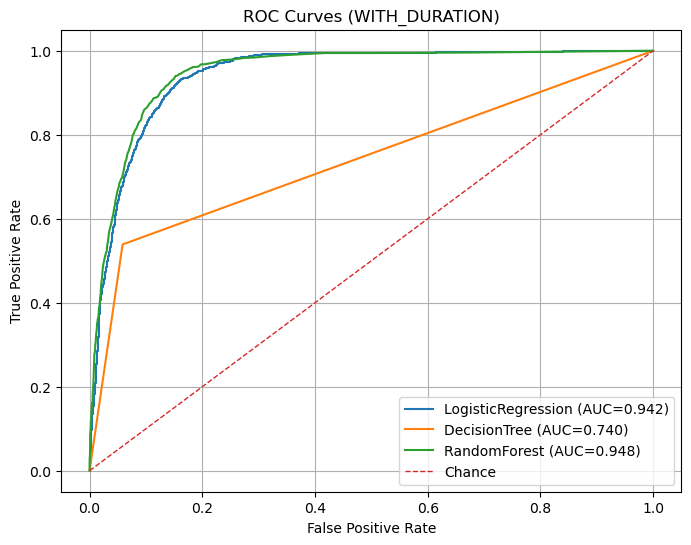

Top 20 features for RandomForest


,feature,importance
0,duration,0.275604
1,euribor3m,0.089149
2,age,0.081391
3,nr.employed,0.050342
4,campaign,0.039708
5,pdays,0.031904
6,cons.conf.idx,0.026639
7,emp.var.rate,0.024893
8,cons.price.idx,0.021355
9,poutcome_success,0.017230


Saved model to: ./outputs/best_pipeline_WITH_DURATION.joblib
\n=============================
Configuration: WITHOUT_DURATION
\n--- Training LogisticRegression ---
LogisticRegression metrics: {'accuracy': 0.9011896091284293, 'precision': 0.69, 'recall': 0.22306034482758622, 'f1': 0.3371335504885994, 'roc_auc': 0.8008559513420445}
[[7217   93]
 [ 721  207]]
              precision    recall  f1-score   support

           0      0.909     0.987     0.947      7310
           1      0.690     0.223     0.337       928

    accuracy                          0.901      8238
   macro avg      0.800     0.605     0.642      8238
weighted avg      0.884     0.901     0.878      8238

\n--- Training DecisionTree ---
DecisionTree metrics: {'accuracy': 0.84122359796067, 'precision': 0.31, 'recall': 0.33405172413793105, 'f1': 0.32157676348547715, 'roc_auc': 0.6239625837303646}
[[6620  690]
 [ 618  310]]
              precision    recall  f1-score   support

           0      0.915     0.906     0.

,model,accuracy,precision,recall,f1,roc_auc
0,RandomForest,0.896455,0.57732,0.301724,0.396320,0.785063
1,LogisticRegression,0.901190,0.69000,0.223060,0.337134,0.800856
2,DecisionTree,0.841224,0.31000,0.334052,0.321577,0.623963


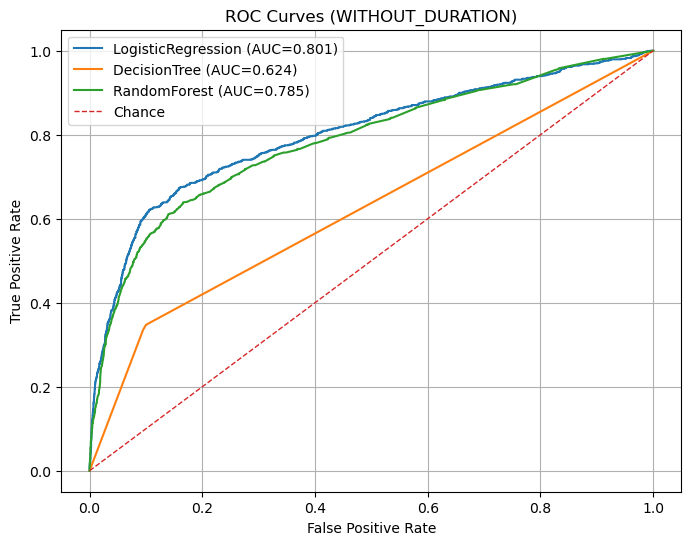

Top 20 features for RandomForest


,feature,importance
0,age,0.157801
1,euribor3m,0.118479
2,campaign,0.081813
3,nr.employed,0.044044
4,pdays,0.035113
5,cons.conf.idx,0.026467
6,emp.var.rate,0.023362
7,poutcome_success,0.023222
8,cons.price.idx,0.021792
9,housing_yes,0.020780


Saved model to: ./outputs/best_pipeline_WITHOUT_DURATION.joblib
\nAll configurations finished. Check the outputs folder for artifacts.


In [39]:
# Run the analysis (cells you execute)

# 1) Load data
print("Loading:", DATA_PATH)
df = pd.read_csv(DATA_PATH)
print("Loaded shape:", df.shape)

# 2) Detect target column
TARGET = detect_target_column(df)
print("Using target column:", TARGET)

# 3) Drop rows with missing target if any
df = df.dropna(subset=[TARGET]).copy()

# 4) EDA
basic_eda(df, TARGET, out_dir=os.path.join(OUTPUT_DIR, "eda_plots"), include_plots=RUN_PLOTS)

# 5) Prepare features and target
X = df.drop(columns=[TARGET])
y = df[TARGET]

# We'll run two configurations: with and without 'duration'
configurations = [("WITH_DURATION", False), ("WITHOUT_DURATION", True)]

for label, drop_duration in configurations:
    print("\\n=============================")
    print("Configuration:", label)
    print("=============================")

    preprocessor, num_features, cat_features = build_preprocessor(df, TARGET, drop_duration=drop_duration)

    # 6) Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

    # 7) Train & evaluate baseline models
    results_df, pipelines, roc_info = train_and_evaluate(X_train, X_test, y_train, y_test, preprocessor, random_state=RANDOM_STATE)
    print("\\nModel comparison for", label)
    display(results_df)

    # Save results
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    results_df.to_csv(os.path.join(OUTPUT_DIR, f"model_results_{label}.csv"), index=False)

    # 8) Plot ROC curves (if available)
    if roc_info:
        plot_roc(roc_info, title=f"ROC Curves ({label})")

    # 9) Optionally tune RandomForest
    if RUN_GRIDSEARCH:
        gs = grid_search_random_forest(X_train, y_train, preprocessor, random_state=RANDOM_STATE)
        best_rf = gs.best_estimator_
        # Evaluate tuned
        y_pred = best_rf.predict(X_test)
        y_proba = None
        if hasattr(best_rf, "predict_proba"):
            proba = best_rf.predict_proba(X_test)
            if proba.shape[1] == 2:
                y_proba = proba[:,1]
        tuned_metrics = evaluate_model(y_test, y_pred, y_proba)
        print("Tuned RF metrics:", tuned_metrics)

    # 10) Feature importance for best pipeline (by f1 in results_df)
    best_model_name = results_df.loc[0, "model"]
    best_pipe = pipelines[best_model_name]
    try:
        imp_df = extract_feature_importance(best_pipe, X_test)
        if not imp_df.empty:
            print("Top 20 features for", best_model_name)
            display(imp_df.head(20))
            imp_df.to_csv(os.path.join(OUTPUT_DIR, f"feature_importance_{label}.csv"), index=False)
    except Exception as e:
        print("Could not extract feature importance:", e)

    # 11) Save best pipeline
    save_pipeline(best_pipe, os.path.join(OUTPUT_DIR, f"best_pipeline_{label}.joblib"))

print("\\nAll configurations finished. Check the outputs folder for artifacts.")
